In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 데이터셋 준비하기

In [3]:
# 스탠포드 개 데이터셋 다운로드
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [8]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    """
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    """
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

In [10]:
# 데이터셋 전처리&배치처리
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치 모양 확인
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


# 베이스 모델 준비

In [4]:
# 데이터셋 클래스 숫자 확인
num_classes = ds_info.features["label"].num_classes
print('num_classes:', num_classes)

num_classes: 120


In [6]:
# 모델 선언
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    # GAP 적용
    pooling='avg',
)

x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [7]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

# 베이스 모델 학습

In [11]:
cam_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy']
)

In [12]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=10,
    validation_data=ds_val_norm,
    # verbose를 1로 주면 학습 중 손실 또는 정확도가 한 에포크 내에 어떻게 변하는지 볼 수 있습니다.
    verbose=1,
    # multiprocessing을 사용할 경우 Worker에서 발생하는 로그가 출력되는 것을 막아줍니다.
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 111s 140ms/step - loss: 2.1890 - accuracy: 0.4552 - val_loss: 3.2761 - val_accuracy: 0.2213
Epoch 2/10
750/750 [==============================] - 102s 136ms/step - loss: 0.7754 - accuracy: 0.7832 - val_loss: 1.0676 - val_accuracy: 0.6848
Epoch 3/10
750/750 [==============================] - 102s 136ms/step - loss: 0.3064 - accuracy: 0.9256 - val_loss: 0.9937 - val_accuracy: 0.7156
Epoch 4/10
750/750 [==============================] - 102s 136ms/step - loss: 0.1116 - accuracy: 0.9822 - val_loss: 0.9272 - val_accuracy: 0.7345
Epoch 5/10
750/750 [==============================] - 102s 136ms/step - loss: 0.0556 - accuracy: 0.9952 - val_loss: 0.9386 - val_accuracy: 0.7358
Epoch 6/10
750/750 [==============================] - 102s 136ms/step - loss: 0.0338 - accuracy: 0.9973 - val_loss: 0.9369 - val_accuracy: 0.7362
Epoch 7/10
750/750 [==============================] - 102s 136ms/step - loss: 0.0229 - accuracy: 0.9980 - val_loss: 0.9425 -

In [13]:
import os

cam_model_path = 'model/cam_model10.h5'

cam_model.save(cam_model_path)

In [14]:
# 모델 불러오기
cam_model = tf.keras.models.load_model(cam_model_path)

# 기본 모델 정의

In [25]:
# 기본 코드 작성
# cam을 적용시키기 위해 사진 1장 선택
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

# CAM이미지 생성 코드
def generate_cam(model, item):
    # 이미지와 라벨 정보 가져오기
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]

    # 이미지 전처리
    img_tensor, class_idx = normalize_and_resize_img(item)

    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]

    # 모델의 weight activation은 마지막 layer에 있슴
    class_weights = model.layers[-1].get_weights()[0]

    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        cam_image += w * conv_outputs[:, :, i]

    # 이미지 후처리
    cam_image /= np.max(cam_image)
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height))
    return cam_image

# CAM 이미지 시각화
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

In [32]:
# Grad-CAM 적용
def generate_grad_cam(model, activation_layer, item):
    # 이미지와 라벨 정보 가져오기
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]

    # 이미지 전처리
    img_tensor, class_idx = normalize_and_resize_img(item)

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape 사용
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
        
        loss = pred[:, class_idx]
        output = conv_output[0]
        grads = tape.gradient(loss, conv_output)[0]

    weights = np.mean(grads, axis=(0, 1))
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        grad_cam_image += w * output[:, :, k]

    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

In [36]:
# Bounding Box 그리기
def get_bbox(cam_iamge, score_thresh=0.05):
    low_indicies = cam_iamge <= score_thresh
    cam_iamge[low_indicies] = 0
    cam_iamge = np.uint8(255 * cam_iamge)

    # 외곽선 구하기
    contours, _ = cv2.findContours(cam_iamge, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [41]:
# IOU 계산
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou


# CAM 구현하기

In [22]:
item = get_one(ds_test)

40


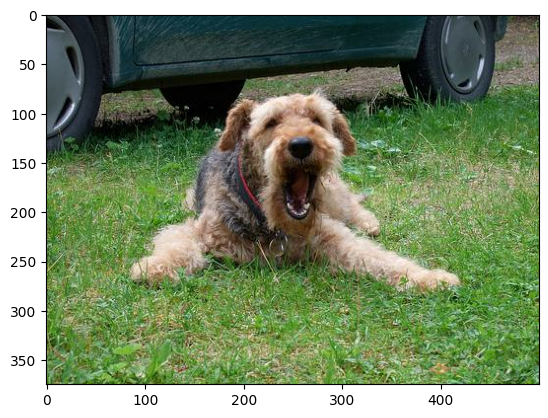

In [24]:
print(item['label'])
plt.imshow(item['image'])
plt.show()

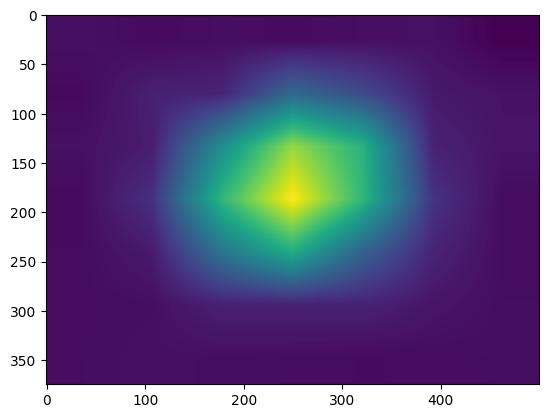

In [23]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

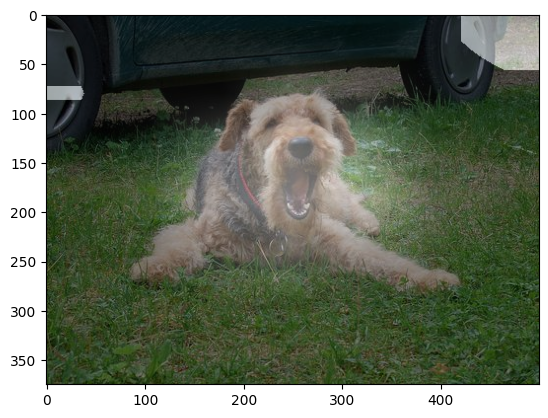

In [26]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

# Grad_Cam 구현하기

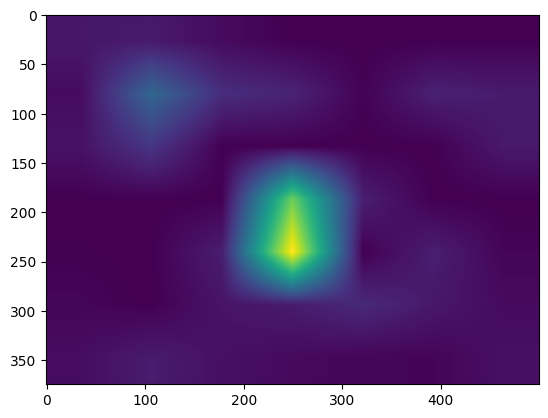

In [33]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

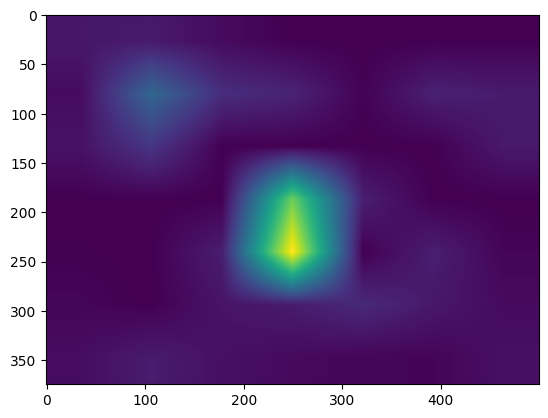

In [34]:
grad_cam_iamge = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

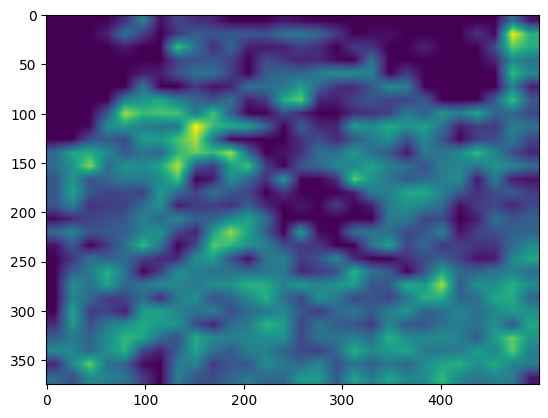

In [35]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

# 바운딩 박스 구하기

C:\Users\ZAMTOL\AppData\Local\Temp\ipykernel_13748\550850412.py:12: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  rect = np.int0(rect)


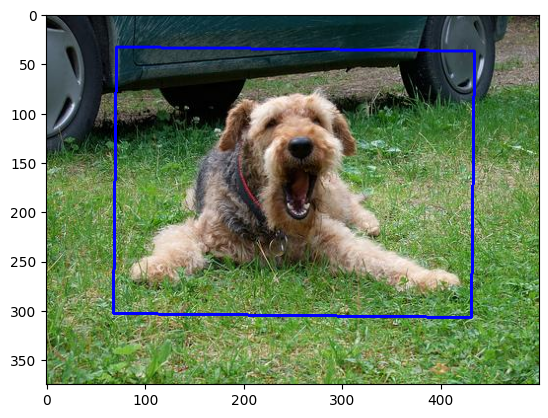

In [38]:
rect = get_bbox(cam_image)
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0, 0, 255), 2)
plt.imshow(image)
plt.show()

# IoU 구하기

In [42]:
pred_bbox = rect_to_minmax(rect, item['image'])
get_iou(pred_bbox, item['objects']['bbox'][0])

0.7115292211418819